In [839]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import seaborn as sns
from sklearn.externals import joblib

import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot, plot


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


from sklearn import linear_model

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgb
from sklearn.decomposition import PCA

import xgboost as xgboost
from xgboost import plot_importance

from xgboost import XGBClassifier
from xgboost import XGBRegressor

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV


# modelling
from scipy import stats
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler


def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (np.abs((y_true - y_pred) / y_true)) * 100

In [840]:
'''
df = pd.read_csv('~/OneDrive - SAP SE/1 Projects/160629_PipelineForecasting/GIT/forXin/LicensesDaily2.csv', 
                 sep = ';',
                decimal = ',')
'''

df = pd.read_csv('/Users/i513088/Desktop/Final-model/LicensesDaily3.csv',
                 sep = ';',
                decimal = ',')

model1 = pd.read_csv('/Users/i513088/Desktop/Final-model/model1_bootstrap/model1_count_all.csv')

# filter relevant regions

In [841]:
df.GLOBAL_01_CODE.unique()

array([nan, 'AP', 'EMEACLOT', 'EMNORTH', 'EMSOUTH', 'GCN', 'GEOOTH', 'LA',
       'MEE', 'NOAM', 'Global', 'GEOBND', 'IFRSADJ'], dtype=object)

In [842]:
df_subset = df.loc[(df['GLOBAL_01_CODE'] == "AP") 
                   | (df['GLOBAL_01_CODE'] == "EMNORTH")
                    | (df['GLOBAL_01_CODE'] == "EMSOUTH")
                    | (df['GLOBAL_01_CODE'] == "GCN")
                    | (df['GLOBAL_01_CODE'] == "LA")
                    | (df['GLOBAL_01_CODE'] == "MEE")
                    | (df['GLOBAL_01_CODE'] == "NOAM"), :]

# Handling time dimensions
### calculate day in quarter
###### some quarter have different durations - I need to ensure that the last days in the quarter match when joining historic data. Missing values for the first day will then simply be filled with the subsequent day

In [843]:
days = df_subset[['SnapDate', 'CLOSING_QUARTER_ACTUAL']].drop_duplicates()

days['DayInQuarter'] = days.sort_values(['SnapDate'], ascending=[False]).groupby(['CLOSING_QUARTER_ACTUAL']).cumcount() + 1
days['DayInQuarter_asc'] = days.sort_values(['SnapDate'], ascending=[True]).groupby(['CLOSING_QUARTER_ACTUAL']).cumcount() + 1

In [844]:
df_subset = pd.merge(df_subset, days[['SnapDate', 'DayInQuarter', 'DayInQuarter_asc']], on = 'SnapDate', how = 'left')

### calculate index for quarter
###### having a running index for quarter will help calculate rolling snapshots

In [845]:
quarter = df_subset[['CLOSING_QUARTER_ACTUAL']].drop_duplicates()

quarter['QuarterIndex'] = quarter.sort_values(['CLOSING_QUARTER_ACTUAL'], ascending=[True]).reset_index().index

quarter['QuarterIndex'] = quarter['QuarterIndex'] + 1

In [846]:
df_subset = pd.merge(df_subset, quarter[['CLOSING_QUARTER_ACTUAL', 'QuarterIndex']], on = 'CLOSING_QUARTER_ACTUAL', how = 'left')

# Fixing Data issues
###### the first two weeks of Q1 2019 contains incorrect values for budget - replacing them with values from day 15

In [847]:
BudgetFix = df_subset.loc[(df_subset['CLOSING_QUARTER_ACTUAL'] == "2019-Q1")  & (df_subset['DayInQuarter_asc'] == 15), :]
BudgetFix['BudgetFix'] = BudgetFix['BUDGET']

/Users/i513088/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [848]:
df_subset = pd.merge(df_subset, BudgetFix[['GLOBAL_01_CODE', 'QuarterIndex', 'BudgetFix']], 
                on = ['GLOBAL_01_CODE', 'QuarterIndex'], how = 'left')

df_subset.loc[(df_subset.DayInQuarter_asc < 15) & (df_subset.CLOSING_QUARTER_ACTUAL == "2019-Q1"), 'BUDGET'] = df_subset['BudgetFix']

df_subset = df_subset.drop("BudgetFix", axis=1)

In [849]:
df_subset = pd.merge(df_subset, model1[['GLOBAL_01_CODE', 'DayInQuarter', 'DayInQuarter_asc', 'QuarterIndex', 'CLOSING_QUARTER_ACTUAL', 'LinearReg', 'ElasticNet', 'GBM', 'MLP']], 
                     on = ['GLOBAL_01_CODE', 'DayInQuarter', 'DayInQuarter_asc', 'QuarterIndex', 'CLOSING_QUARTER_ACTUAL'], how = 'left')

## Manipulate Quarter Index to "bootstrap" - swapping the holdout sample

In [801]:
df_subset.loc[df_subset.CLOSING_QUARTER_ACTUAL == '2018-Q4', 'QuarterIndex'] = 5
df_subset.loc[df_subset.CLOSING_QUARTER_ACTUAL == '2019-Q1', 'QuarterIndex'] = 4

# creation of Analytical dataset

#### Initiating dataset by selecting straightforward entries first (time dimensions, dependent variable, Estimated In, Open Pipe)

In [850]:
#df_subset['DV'] = df_subset.NonExistent + df_subset.FutureQuarter_Commit + df_subset.FutureQuarter_Probable + df_subset.FutureQuarter_Upside
df_subset['DV'] = df_subset.ACTUAL - df_subset.ESTIMATED_IN - df_subset.CurrentQuarter_Commit - df_subset.CurrentQuarterProbable - df_subset.CurrentQuarter_Upside

# Exploratory Analysis

### Opportunities with a qualification status of upside / probable show a different closing probability throughout the quarter. To account for this teh open opportunity value need to be adjusted.

## <font color='red'>Transform data way: by region but across quarter. <font>

In [852]:
dummy = df_subset[df_subset.QuarterIndex < 5].copy(deep=True)

dummy.loc[dummy.DayInQuarter > 90, 'DayInQuarter'] = 90

dummy = dummy[['GLOBAL_01_CODE', 'DayInQuarter', 'Count_Open_AB', 'Count_Open_CD', 'Count_Open_EF', 'Count_Open_Commit', 'Count_Open_Probable', 'Count_Open_Upside',
               'Count_AB', 'Count_CD', 'Count_EF', 'Count_Commit', 'Count_Probable', 'Count_Upside',
               'Open_Commit', 'Open_Probable', 'Open_Upside', 'CurrentQuarter_Commit', 'CurrentQuarterProbable', 'CurrentQuarter_Upside']]


dummy['FactorCommit'] = dummy['Count_Commit'] / dummy['Count_Open_Commit']
dummy['FactorProbable'] = dummy['Count_Probable'] / dummy['Count_Open_Probable']
dummy['FactorUpside'] = dummy['Count_Upside'] / dummy['Count_Open_Upside']


ClosingRates = dummy[['GLOBAL_01_CODE', 'DayInQuarter', 'FactorCommit', 'FactorProbable', 'FactorUpside']]

ClosingRates = dummy.groupby(by = ['GLOBAL_01_CODE', 'DayInQuarter']).mean().reset_index()

In [853]:
df_subset = pd.merge(df_subset, ClosingRates[['GLOBAL_01_CODE', 'DayInQuarter', 'FactorCommit', 'FactorProbable', 'FactorUpside']], 
                on = ['GLOBAL_01_CODE', 'DayInQuarter'], how = 'left')

df_subset['Open_Commit_adj'] = df_subset['Open_Commit'] * df_subset['FactorCommit']
df_subset['Open_Probable_adj'] = df_subset['Open_Probable'] * df_subset['FactorProbable']
df_subset['Open_Upside_adj'] = df_subset['Open_Upside'] * df_subset['FactorUpside']
df_subset['OpenPipe_adj'] = df_subset['Open_Upside_adj'] + df_subset['Open_Probable_adj'] + df_subset['Open_Commit_adj']

In [854]:
ad_1 = df_subset[['SnapDate', 'CLOSING_QUARTER_ACTUAL', 'GLOBAL_01_CODE', 'DayInQuarter', 'DayInQuarter_asc', 'QuarterIndex', 'ACTUAL',
                  'ESTIMATED_IN', 'OpenPipe', 'OpenPipe_adj', 'DV', 'BUDGET',
                 'LinearReg', 'ElasticNet', 'GBM', 'MLP']]

### Linearity based on last quarter

In [855]:
dummy0 = df_subset[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN', 'BUDGET', 'DV']]
dummy1 = dummy0.copy(deep=True)

dummy1['QuarterIndex'] = dummy1['QuarterIndex'] + 1
dummy1['ESTIMATED_IN_tm1'] = dummy1['ESTIMATED_IN']
dummy1['DV_tm1'] = dummy1['DV']
dummy1['BUDGET_tm1'] = dummy1['BUDGET']

dummy0 = pd.merge(dummy0, dummy1[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN_tm1', 'DV_tm1', 'BUDGET_tm1']], 
                  on = ['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex'], how = 'left')

In [856]:
dummy0['Linearity_EstIn_1Q'] = dummy0.DV_tm1 / dummy0.ESTIMATED_IN_tm1
dummy0['Linearity_Budget_1Q'] = dummy0.DV_tm1 / dummy0.BUDGET_tm1

In [857]:
ad_2 = pd.merge(ad_1, dummy0[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q']], 
                on = ['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex'], how = 'left')

### Linearity based on quarter - 2

In [858]:
dummy0 = df_subset[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN', 'BUDGET', 'DV']]
dummy2 = dummy0.copy(deep=True)

dummy2['QuarterIndex'] = dummy2['QuarterIndex'] + 2
dummy2['ESTIMATED_IN_tm2'] = dummy2['ESTIMATED_IN']
dummy2['DV_tm2'] = dummy2['DV']
dummy2['BUDGET_tm2'] = dummy2['BUDGET']

dummy0 = pd.merge(dummy0, dummy2[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN_tm2', 'DV_tm2', 'BUDGET_tm2']], 
                  on = ['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex'], how = 'left')

In [859]:
dummy0['Linearity_EstIn_2Q'] = dummy0.DV_tm2 / dummy0.ESTIMATED_IN_tm2
dummy0['Linearity_Budget_2Q'] = dummy0.DV_tm2 / dummy0.BUDGET_tm2

In [860]:
ad_3 = pd.merge(ad_2, dummy0[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'Linearity_EstIn_2Q', 'Linearity_Budget_2Q']], 
                on = ['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex'], how = 'left')

### Linearity based on quarter - 3

In [861]:
dummy0 = df_subset[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN', 'BUDGET', 'DV']]
dummy3 = dummy0.copy(deep=True)

dummy3['QuarterIndex'] = dummy3['QuarterIndex'] + 3
dummy3['ESTIMATED_IN_tm3'] = dummy3['ESTIMATED_IN']
dummy3['DV_tm3'] = dummy3['DV']
dummy3['BUDGET_tm3'] = dummy3['BUDGET']

dummy0 = pd.merge(dummy0, dummy3[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN_tm3', 'DV_tm3', 'BUDGET_tm3']], 
                  on = ['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex'], how = 'left')

In [862]:
dummy0['Linearity_EstIn_3Q'] = dummy0.DV_tm3 / dummy0.ESTIMATED_IN_tm3
dummy0['Linearity_Budget_3Q'] = dummy0.DV_tm3 / dummy0.BUDGET_tm3

In [863]:
ad_4 = pd.merge(ad_3, dummy0[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'Linearity_EstIn_3Q', 'Linearity_Budget_3Q']], 
                on = ['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex'], how = 'left')

### Linearity based on quarter - 4

In [864]:
dummy0 = df_subset[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN', 'BUDGET', 'DV']]
dummy4 = dummy0.copy(deep=True)

dummy4['QuarterIndex'] = dummy4['QuarterIndex'] + 4
dummy4['ESTIMATED_IN_tm4'] = dummy4['ESTIMATED_IN']
dummy4['DV_tm4'] = dummy4['DV']
dummy4['BUDGET_tm4'] = dummy4['BUDGET']

dummy0 = pd.merge(dummy0, dummy4[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN_tm4', 'DV_tm4', 'BUDGET_tm4']], 
                  on = ['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex'], how = 'left')

In [865]:
dummy0['Linearity_EstIn_4Q'] = dummy0.DV_tm4 / dummy0.ESTIMATED_IN_tm4
dummy0['Linearity_Budget_4Q'] = dummy0.DV_tm4 / dummy0.BUDGET_tm4

In [866]:
ad_5 = pd.merge(ad_4, dummy0[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'Linearity_EstIn_4Q', 'Linearity_Budget_4Q']], 
                on = ['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex'], how = 'left')

### build rolling average
###### historic quarter are not necessarily availble. Thus a rolling average is only build based on available data by replacing missing values with 0 and then count non zeros for average creation

In [867]:
# replacing missing values

ad_5.loc[pd.isnull(ad_5["Linearity_EstIn_1Q"]) == True, 'Linearity_EstIn_1Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_EstIn_2Q"]) == True, 'Linearity_EstIn_2Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_EstIn_3Q"]) == True, 'Linearity_EstIn_3Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_EstIn_4Q"]) == True, 'Linearity_EstIn_4Q'] = 0

ad_5.loc[pd.isnull(ad_5["Linearity_Budget_1Q"]) == True, 'Linearity_Budget_1Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_Budget_2Q"]) == True, 'Linearity_Budget_2Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_Budget_3Q"]) == True, 'Linearity_Budget_3Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_Budget_4Q"]) == True, 'Linearity_Budget_4Q'] = 0

ad_5.loc[ad_5.Linearity_EstIn_1Q < 0, 'Linearity_EstIn_1Q'] = 0
ad_5.loc[ad_5.Linearity_EstIn_2Q < 0, 'Linearity_EstIn_2Q'] = 0
ad_5.loc[ad_5.Linearity_EstIn_3Q < 0, 'Linearity_EstIn_3Q'] = 0
ad_5.loc[ad_5.Linearity_EstIn_4Q < 0, 'Linearity_EstIn_4Q'] = 0

ad_5.loc[ad_5.Linearity_Budget_1Q < 0, 'Linearity_Budget_1Q'] = 0
ad_5.loc[ad_5.Linearity_Budget_2Q < 0, 'Linearity_Budget_2Q'] = 0
ad_5.loc[ad_5.Linearity_Budget_3Q < 0, 'Linearity_Budget_3Q'] = 0
ad_5.loc[ad_5.Linearity_Budget_4Q < 0, 'Linearity_Budget_4Q'] = 0

# count populated entries

ad_5['LinearityEstIn_Counter'] = 0
ad_5['LinearityBudget_Counter'] = 0

ad_5.loc[ad_5.Linearity_EstIn_1Q > 0, 'LinearityEstIn_Counter'] = ad_5['LinearityEstIn_Counter'] + 1
ad_5.loc[ad_5.Linearity_EstIn_2Q > 0, 'LinearityEstIn_Counter'] = ad_5['LinearityEstIn_Counter']  + 1
ad_5.loc[ad_5.Linearity_EstIn_3Q > 0, 'LinearityEstIn_Counter'] = ad_5['LinearityEstIn_Counter']  + 1
ad_5.loc[ad_5.Linearity_EstIn_4Q > 0, 'LinearityEstIn_Counter'] = ad_5['LinearityEstIn_Counter']  + 1

ad_5.loc[ad_5.Linearity_Budget_1Q > 0, 'LinearityBudget_Counter'] = ad_5['LinearityBudget_Counter'] + 1
ad_5.loc[ad_5.Linearity_Budget_2Q > 0, 'LinearityBudget_Counter'] = ad_5['LinearityBudget_Counter'] + 1
ad_5.loc[ad_5.Linearity_Budget_3Q > 0, 'LinearityBudget_Counter'] = ad_5['LinearityBudget_Counter'] + 1
ad_5.loc[ad_5.Linearity_Budget_4Q > 0, 'LinearityBudget_Counter'] = ad_5['LinearityBudget_Counter'] + 1

# rolling average

ad_5['LinearityEstIn_rolling'] =0
ad_5['LinearityBudget_rolling'] = 0

ad_5['LinearityEstIn_rolling'] = (ad_5['Linearity_EstIn_1Q'] + 
                                 ad_5['Linearity_EstIn_2Q'] +
                                 ad_5['Linearity_EstIn_3Q'] +
                                 ad_5['Linearity_EstIn_4Q']) / ad_5['LinearityEstIn_Counter'] * ad_5['ESTIMATED_IN']
ad_5['LinearityBudget_rolling'] = (ad_5['Linearity_Budget_1Q'] + 
                                 ad_5['Linearity_Budget_2Q'] +
                                 ad_5['Linearity_Budget_3Q'] +
                                 ad_5['Linearity_Budget_4Q']) / ad_5['LinearityBudget_Counter'] * ad_5['BUDGET']

### add delta EstIn / OpenPipe
###### calculating the difference between two snapshots to be used as an independent variable

In [868]:
dummy0 = df_subset[['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex', 'ESTIMATED_IN', 'OpenPipe']]
dummy1 = dummy0.copy(deep=True)

dummy1['DayInQuarter_asc'] = dummy1['DayInQuarter_asc'] + 1
dummy1['ESTIMATED_IN_dm1'] = dummy1['ESTIMATED_IN']
dummy1['OpenPipe_dm1'] = dummy1['OpenPipe']

dummy0 = pd.merge(dummy0, dummy1[['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex', 'ESTIMATED_IN_dm1', 'OpenPipe_dm1']], 
                  on = ['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex'], how = 'left')

In [869]:
dummy0['Delta_EstIn'] = dummy0.ESTIMATED_IN - dummy0.ESTIMATED_IN_dm1 
dummy0['Delta_OpenPipe'] = dummy0.OpenPipe - dummy0.OpenPipe_dm1 

In [870]:
ad_6 = pd.merge(ad_5, dummy0[['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex', 'Delta_EstIn', 'Delta_OpenPipe']], 
                on = ['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex'], how = 'left')

#### <font color='blue'>calculating the stimation for the gap (Budget - estimation model 1 - estimated in)<font>

### <font color='red'>Here we define the new variable 'Estimated_Gap' !!<font>

In [871]:
ad_6['Estimated_Gap'] = ad_6['BUDGET'] - ad_6['ESTIMATED_IN'] - ad_6['OpenPipe_adj']
# ad_6['Estimated_Gap'] = ad_6['BUDGET'] - ad_6['ESTIMATED_IN'] - ad_6['MLP']

ad_6.loc[ad_6.Estimated_Gap < 0, 'Estimated_Gap'] = 0

In [872]:
ad_6['Estimated_Gap'].shape

(3185,)

# Final Variable Selection

In [873]:
AnalyticalData = ad_6[['SnapDate',
                      'DayInQuarter',
                      'DayInQuarter_asc',
                       'GLOBAL_01_CODE',
                      'CLOSING_QUARTER_ACTUAL',
                      'QuarterIndex',
                       'ACTUAL',
                       'BUDGET',
                      'DV',
                       'OpenPipe_adj',
                       'OpenPipe',
                       'Estimated_Gap',
                      'ESTIMATED_IN',
                       'Linearity_EstIn_1Q',
                      'Linearity_Budget_1Q',
                      'LinearityEstIn_rolling',
                      'LinearityBudget_rolling',
                      'Delta_EstIn',
                      'Delta_OpenPipe']]

AnalyticalData['Linearity_EstIn_1Q'] = AnalyticalData['Linearity_EstIn_1Q'] * AnalyticalData['ESTIMATED_IN']
AnalyticalData['Linearity_Budget_1Q'] = AnalyticalData['Linearity_Budget_1Q'] * AnalyticalData['BUDGET']

AnalyticalData = AnalyticalData.replace([np.inf, -np.inf, np.nan], np.nan)
AnalyticalData.Estimated_Gap = AnalyticalData.Estimated_Gap.fillna(0)

/Users/i513088/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/i513088/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



##### not all quarter have the same amount of days - in these cases missing values for independet variables can occur and are replaced with data from the following day. This data would be available given that the Analytical dataset contains only historic data resp. derivates from historic data
##### populate day 2 with day 3

In [874]:
dummy0 = AnalyticalData.loc[AnalyticalData['DayInQuarter_asc'] == 3,
    ['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q',
    'LinearityEstIn_rolling', 'LinearityBudget_rolling', 'Delta_EstIn', 'Delta_OpenPipe']].copy(deep=True)
#dummy1 = dummy0.copy(deep=True)

dummy0['DayInQuarter_asc'] = dummy0['DayInQuarter_asc'] - 1
dummy0['fix1'] = dummy0['Linearity_EstIn_1Q']
dummy0['fix2'] = dummy0['Linearity_Budget_1Q']
dummy0['fix3'] = dummy0['LinearityEstIn_rolling']
dummy0['fix4'] = dummy0['LinearityBudget_rolling']
dummy0['fix5'] = dummy0['Delta_EstIn']
dummy0['fix6'] = dummy0['Delta_OpenPipe']

AnalyticalData = pd.merge(AnalyticalData, dummy0[['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex', 
                                                  'fix1', 'fix2', 'fix3', 'fix4', 'fix5', 'fix6',]], 
                  on = ['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex'], how = 'left')

AnalyticalData.loc[(pd.isnull(AnalyticalData["Linearity_EstIn_1Q"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'Linearity_EstIn_1Q'] = AnalyticalData['fix1']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Linearity_Budget_1Q"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'Linearity_Budget_1Q'] = AnalyticalData['fix2']
AnalyticalData.loc[(pd.isnull(AnalyticalData["LinearityEstIn_rolling"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'LinearityEstIn_rolling'] = AnalyticalData['fix3']
AnalyticalData.loc[(pd.isnull(AnalyticalData["LinearityBudget_rolling"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'LinearityBudget_rolling'] = AnalyticalData['fix4']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Delta_EstIn"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'Delta_EstIn'] = AnalyticalData['fix5']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Delta_OpenPipe"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'Delta_OpenPipe'] = AnalyticalData['fix6']

AnalyticalData = AnalyticalData.drop("fix1", axis=1)
AnalyticalData = AnalyticalData.drop("fix2", axis=1)
AnalyticalData = AnalyticalData.drop("fix3", axis=1)
AnalyticalData = AnalyticalData.drop("fix4", axis=1)
AnalyticalData = AnalyticalData.drop("fix5", axis=1)
AnalyticalData = AnalyticalData.drop("fix6", axis=1)

##### populate day 1 with day 2

In [875]:
dummy0 = AnalyticalData.loc[AnalyticalData['DayInQuarter_asc'] == 2,
    ['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q',
    'LinearityEstIn_rolling', 'LinearityBudget_rolling', 'Delta_EstIn', 'Delta_OpenPipe']].copy(deep=True)
#dummy1 = dummy0.copy(deep=True)

dummy0['DayInQuarter_asc'] = dummy0['DayInQuarter_asc'] - 1
dummy0['fix1'] = dummy0['Linearity_EstIn_1Q']
dummy0['fix2'] = dummy0['Linearity_Budget_1Q']
dummy0['fix3'] = dummy0['LinearityEstIn_rolling']
dummy0['fix4'] = dummy0['LinearityBudget_rolling']
dummy0['fix5'] = dummy0['Delta_EstIn']
dummy0['fix6'] = dummy0['Delta_OpenPipe']

AnalyticalData = pd.merge(AnalyticalData, dummy0[['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex', 
                                                  'fix1', 'fix2', 'fix3', 'fix4', 'fix5', 'fix6',]], 
                  on = ['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex'], how = 'left')

AnalyticalData.loc[(pd.isnull(AnalyticalData["Linearity_EstIn_1Q"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'Linearity_EstIn_1Q'] = AnalyticalData['fix1']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Linearity_Budget_1Q"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'Linearity_Budget_1Q'] = AnalyticalData['fix2']
AnalyticalData.loc[(pd.isnull(AnalyticalData["LinearityEstIn_rolling"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'LinearityEstIn_rolling'] = AnalyticalData['fix3']
AnalyticalData.loc[(pd.isnull(AnalyticalData["LinearityBudget_rolling"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'LinearityBudget_rolling'] = AnalyticalData['fix4']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Delta_EstIn"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'Delta_EstIn'] = AnalyticalData['fix5']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Delta_OpenPipe"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'Delta_OpenPipe'] = AnalyticalData['fix6']

AnalyticalData = AnalyticalData.drop("fix1", axis=1)
AnalyticalData = AnalyticalData.drop("fix2", axis=1)
AnalyticalData = AnalyticalData.drop("fix3", axis=1)
AnalyticalData = AnalyticalData.drop("fix4", axis=1)
AnalyticalData = AnalyticalData.drop("fix5", axis=1)
AnalyticalData = AnalyticalData.drop("fix6", axis=1)

##### populate remaining missing values

In [876]:
AnalyticalData.loc[pd.isnull(AnalyticalData["Estimated_Gap"]) == True, 'ESTIMATED_IN'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["ESTIMATED_IN"]) == True, 'ESTIMATED_IN'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["OpenPipe"]) == True, 'OpenPipe'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Linearity_EstIn_1Q"]) == True, 'Linearity_EstIn_1Q'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Linearity_Budget_1Q"]) == True, 'Linearity_Budget_1Q'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["LinearityEstIn_rolling"]) == True, 'LinearityEstIn_rolling'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["LinearityBudget_rolling"]) == True, 'LinearityBudget_rolling'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Delta_EstIn"]) == True, 'Delta_EstIn'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Delta_OpenPipe"]) == True, 'Delta_OpenPipe'] = 0

### There are outliers in the data - thus the independent variables which represents estimator of the depnedent variable get limited to a corridor between 
#### upper limit: 60% of budget on day 1 to 30% of budget on day 90
#### lower limit: 30% of budget on day 1 to 0% of budget on day 90

In [877]:
from pivottablejs import pivot_ui

AnalyticalData['Ratio_DVBud'] = AnalyticalData['DV'] / AnalyticalData['BUDGET']
pivot_ui(AnalyticalData.loc[AnalyticalData.DayInQuarter_asc == 1, 
                            ['CLOSING_QUARTER_ACTUAL', 'GLOBAL_01_CODE', 'Ratio_DVBud']],
                       rows=['GLOBAL_01_CODE'],
                       aggregatorName='Maximum',
                        vals=['Ratio_DVBud'])

### <font color='red'>still don't understand the reason why we set the Boundary by this way？<font>

In [878]:
AnalyticalData['UpperBoundary'] = AnalyticalData['BUDGET'] * 0.6 - (AnalyticalData['BUDGET'] * 0.6 * ((AnalyticalData['DayInQuarter_asc'] - 1) / 180))
AnalyticalData['LowerBoundary'] = AnalyticalData['BUDGET'] * 0.3 - (AnalyticalData['BUDGET'] * 0.3 * ((AnalyticalData['DayInQuarter_asc'] - 1) / 90))

AnalyticalData.loc[AnalyticalData.UpperBoundary < 0, 'UpperBoundary'] = 0
AnalyticalData.loc[AnalyticalData.LowerBoundary < 0, 'LowerBoundary'] = 0

AnalyticalData.loc[AnalyticalData.Linearity_Budget_1Q > AnalyticalData.UpperBoundary, 
                   'Linearity_Budget_1Q'] = AnalyticalData.UpperBoundary
AnalyticalData.loc[AnalyticalData.Linearity_EstIn_1Q > AnalyticalData.UpperBoundary, 
                   'Linearity_EstIn_1Q'] = AnalyticalData.UpperBoundary
AnalyticalData.loc[AnalyticalData.LinearityEstIn_rolling > AnalyticalData.UpperBoundary, 
                   'LinearityEstIn_rolling'] = AnalyticalData.UpperBoundary
AnalyticalData.loc[AnalyticalData.LinearityBudget_rolling > AnalyticalData.UpperBoundary, 
                   'LinearityBudget_rolling'] = AnalyticalData.UpperBoundary

AnalyticalData.loc[AnalyticalData.Linearity_Budget_1Q < AnalyticalData.LowerBoundary, 
                   'Linearity_Budget_1Q'] = AnalyticalData.LowerBoundary
AnalyticalData.loc[AnalyticalData.Linearity_EstIn_1Q < AnalyticalData.LowerBoundary, 
                   'Linearity_EstIn_1Q'] = AnalyticalData.LowerBoundary
AnalyticalData.loc[AnalyticalData.LinearityEstIn_rolling < AnalyticalData.LowerBoundary, 
                   'LinearityEstIn_rolling'] = AnalyticalData.LowerBoundary
AnalyticalData.loc[AnalyticalData.LinearityBudget_rolling < AnalyticalData.LowerBoundary, 
                   'LinearityBudget_rolling'] = AnalyticalData.LowerBoundary

In [879]:
#AnalyticalData.to_csv("~/Desktop/Final-model/AnalyticalData_model2_CountQualification.csv")

#AnalyticalData = pd.read_csv("~/Desktop/Final-model/AnalyticalData_model2_CountQualification.csv")

In [880]:
AnalyticalData[AnalyticalData.QuarterIndex == 5].head(1)

,SnapDate,DayInQuarter,DayInQuarter_asc,GLOBAL_01_CODE,CLOSING_QUARTER_ACTUAL,QuarterIndex,ACTUAL,BUDGET,DV,OpenPipe_adj,...,ESTIMATED_IN,Linearity_EstIn_1Q,Linearity_Budget_1Q,LinearityEstIn_rolling,LinearityBudget_rolling,Delta_EstIn,Delta_OpenPipe,Ratio_DVBud,UpperBoundary,LowerBoundary
2555,2019-01-01,90,1,AP,2019-Q1,5,97929.92153,104904.04286,44175.058718,40401.775427,...,9028.189949,62942.425716,53929.437244,62942.425716,50890.227694,33.591131,-12207.70556,0.4211,62942.425716,31471.212858


# ------------------------------------------
# MODELING
# ------------------------------------------

## <font color='red'>------------------------------------------<font>
## <font color='red'>Here is Xin's part<font>


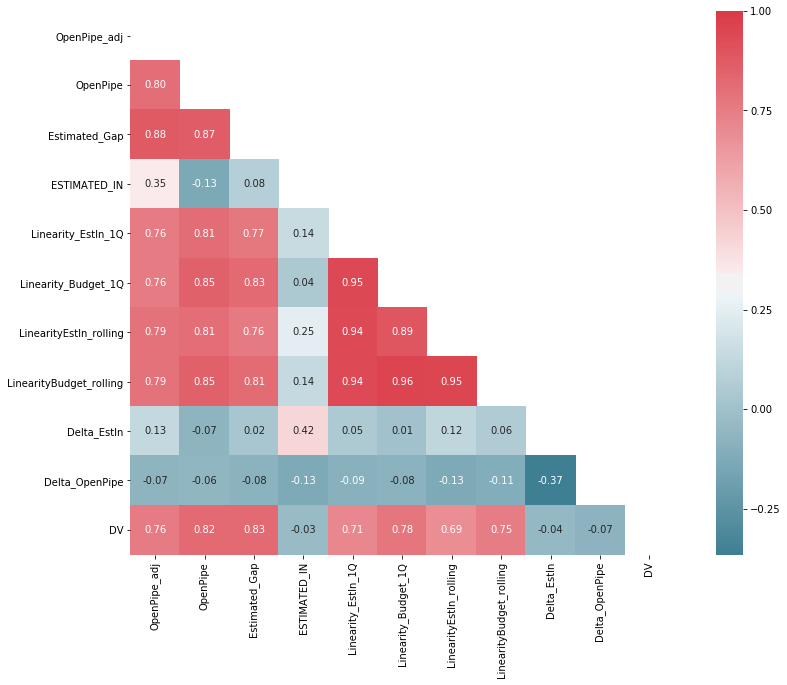

In [570]:
features = AnalyticalData.loc[: , 'OpenPipe_adj' : 'Delta_OpenPipe']
features = pd.concat([features, AnalyticalData['DV']], axis=1)

plt.figure(figsize=(15, 10))  
colnm = features.columns.tolist()
mcorr = features[colnm].corr(method="spearman")  
mask = np.zeros_like(mcorr, dtype=np.bool)  
mask[np.triu_indices_from(mask)] = True 
cmap = sns.diverging_palette(220, 10, as_cmap=True)  
g = sns.heatmap(mcorr,  mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  
plt.show()

In [571]:
list(AnalyticalData)

['SnapDate',
 'DayInQuarter',
 'DayInQuarter_asc',
 'GLOBAL_01_CODE',
 'CLOSING_QUARTER_ACTUAL',
 'QuarterIndex',
 'ACTUAL',
 'BUDGET',
 'DV',
 'OpenPipe_adj',
 'OpenPipe',
 'Estimated_Gap',
 'ESTIMATED_IN',
 'Linearity_EstIn_1Q',
 'Linearity_Budget_1Q',
 'LinearityEstIn_rolling',
 'LinearityBudget_rolling',
 'Delta_EstIn',
 'Delta_OpenPipe',
 'UpperBoundary',
 'LowerBoundary']

### Here is the training process

In [296]:
train = AnalyticalData[(AnalyticalData.QuarterIndex > 1) & (AnalyticalData.QuarterIndex < 5)]
holdout = AnalyticalData[(AnalyticalData.QuarterIndex == 5)].reset_index()
holdout = holdout.sort_values(['GLOBAL_01_CODE', 'SnapDate']).reset_index()

In [297]:
train_x=train.loc[: , ['Estimated_Gap',
                       'ESTIMATED_IN',
                         'Linearity_EstIn_1Q',
                         'Linearity_Budget_1Q',
                         'LinearityEstIn_rolling',
                         'LinearityBudget_rolling',
                        ]]
train_y=train.DV

test_x=holdout.loc[: , ['Estimated_Gap',
                        'ESTIMATED_IN',
                         'Linearity_EstIn_1Q',
                         'Linearity_Budget_1Q',
                         'LinearityEstIn_rolling',
                         'LinearityBudget_rolling'
                        ]]
test_y=holdout.DV

In [250]:
list(AnalyticalData)

['SnapDate',
 'DayInQuarter',
 'DayInQuarter_asc',
 'GLOBAL_01_CODE',
 'CLOSING_QUARTER_ACTUAL',
 'QuarterIndex',
 'ACTUAL',
 'BUDGET',
 'DV',
 'OpenPipe_adj',
 'OpenPipe',
 'Estimated_Gap',
 'ESTIMATED_IN',
 'Linearity_EstIn_1Q',
 'Linearity_Budget_1Q',
 'LinearityEstIn_rolling',
 'LinearityBudget_rolling',
 'Delta_EstIn',
 'Delta_OpenPipe',
 'UpperBoundary',
 'LowerBoundary']

In [1596]:
def train_model(model, param_grid, X=[], y=[], eval_set=[]):
        
    # setup grid search parameters
    gsearch = GridSearchCV(model, param_grid, verbose=0)

    gsearch.fit(X,y)

    # extract best model from the grid
    model = gsearch.best_estimator_        
    best_idx = gsearch.best_index_
    
    #joblib.dump(model, '/Users/i513088/Desktop/' + str(model)[:20] + '.pkl')
    y_train_pred = model.predict(X)
    
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('Train MAPE:',np.mean(MAPE(y_train_pred, y)))
    
    return model


def model_predict(model, x_test,y_test):
    
    y_predict = model.predict(x_test)

    mape = np.mean(MAPE(y_predict, y_test))
    
    y_pred_model2[model] = pd.Series(y_predict)
    
    y_pred_model2[str(model)[:20]+'mape'] = pd.Series(MAPE(y_predict, y_test))
    
    y_pred_model2.to_csv('/Users/i513088/Desktop/y_pred_model2_count_MLP_Q5.csv')

    print('The model',model, 'test mape is:', mape)
    print('Finished!')

    return y_predict
    

In [1597]:
y_pred_model2 = pd.DataFrame()

# Here I use the K-Fold validation set, but we can igore this step
X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, test_size=0.15)

In [1598]:
model_name = 'Linear'
model = linear_model.LinearRegression()
fit_intercept = [False]
param_grid = {'fit_intercept': fit_intercept}
LinearReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
LinearReg_Pred = model_predict(LinearReg,test_x,test_y)
LinearReg_coef = LinearReg.coef_



model_name ='ElasticNet'
model = ElasticNet()
param_grid = {'alpha': np.arange(0.1,6,0.25),
              'l1_ratio': np.arange(0.1,1.0,0.1),
              'max_iter':[100000]}
ElasticReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
ElasticReg_coef = ElasticReg.coef_

ElasticReg_Pred = model_predict(ElasticReg,test_x, test_y)



model_name = 'GradientBoosting'
model = GradientBoostingRegressor()
param_grid = {'n_estimators':[150,250,350],
              'max_depth':[2,3,4,5],
              'min_samples_split':[5,6,7]}
GBM = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
GBM_Pred = model_predict(GBM, test_x,test_y)



model_name = 'XGB'
model = XGBRegressor()
param_grid = {'n_estimators':[100,200,300,400],
              'max_depth':[2,3,4,5],
             }
XGB = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
XGB_Pred = model_predict(XGB,test_x,test_y)



'''
model_name = 'Lasso'
model = Lasso()
fit_intercept = [False]
alph_range = np.arange(0.1,6,0.25)
param_grid = {'alpha': alph_range, 'fit_intercept': fit_intercept}
LassoReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
LassoReg_coef = LassoReg.coef_
LassoReg_Pred = model_predict(LassoReg,test_x,test_y)
'''


'''
model_name = 'RandomForest'
model = RandomForestRegressor()
param_grid = {'n_estimators':[100,150,200],
              'min_samples_split':[2,4,6]
             }
RF = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
RF_Pred = model_predict(RF,test_x,test_y)
'''

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.



----------------------
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)
----------------------
Train MAPE: 37.51052596447084
The model LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False) test mape is: 102.40702203070562
Finished!
----------------------
ElasticNet(alpha=5.849999999999999, copy_X=True, fit_intercept=True,
      l1_ratio=0.9, max_iter=100000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)
----------------------
Train MAPE: 296.65777383175214
The model ElasticNet(alpha=5.849999999999999, copy_X=True, fit_intercept=True,
      l1_ratio=0.9, max_iter=100000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False) test mape is: 307.2301416132203
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.



----------------------
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=350, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
----------------------
Train MAPE: 4.587761678443183
The model GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=350, n_iter_no_change=None, 

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.



----------------------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
----------------------
Train MAPE: 4.217738682664848
The model XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1) test mape is: 217.40383627695806
Finished!


"\nmodel_name = 'RandomForest'\nmodel = RandomForestRegressor()\nparam_grid = {'n_estimators':[100,150,200],\n              'min_samples_split':[2,4,6]\n             }\nRF = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])\nRF_Pred = model_predict(RF,test_x,test_y)\n"

### MLP

In [1599]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import RMSprop
from keras import optimizers


batch_size = 50
epochs = 600
input_shape=(6,)
    
kf = KFold(n_splits=4, random_state=None, shuffle=True)

# Building the MLP model

model = Sequential()

model.reset_states() 
model.add(Dense(256,activation='linear',input_shape=input_shape))
#model.add(Dense(128,activation='relu',input_shape=input_shape))
#model.add(Dense(128,activation='linear'))
model.add(Dense(64,activation='linear'))
model.add(Dense(32,activation='linear'))
model.add(Dense(1,activation='linear'))


model.compile(loss='mae', optimizer=optimizers.Adagrad(lr=0.15, epsilon=None, decay=0.01))

model.summary()

for train_index, test_index in kf.split(train_x):
    
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    x_train, x_test = train_x.iloc[train_index], train_x.iloc[test_index]
    y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]

    x_train = np.reshape(x_train,(len(x_train),6))
    x_test = np.reshape(x_test,(len(x_test),6))
    
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    x_test = x_test.astype('float32')
    y_test = y_test.astype('float32')
    
    model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(x_test,y_test))


predicted_train = model.predict(train_x)
predicted_train = np.reshape(predicted_train, np.shape(train_y))
mape_train = np.mean(MAPE(train_y, predicted_train))


predicted_test = model.predict(test_x)
mlp_predicted_test = np.reshape(predicted_test, np.shape(test_y))
mape_test = np.mean(MAPE(mlp_predicted_test, test_y))


y_pred_model2['MLP'] = pd.Series(mlp_predicted_test)
    
y_pred_model2['MLP_mape'] = pd.Series(MAPE(mlp_predicted_test, test_y))
    
y_pred_model2.to_csv('/Users/i513088/Desktop/y_pred_model2_count_MLP_Q5.csv')
    
    
print('mae score_train:',score_train)
print('MAPE_train is: ', mape_train,'%')

print('mae score_test:',score_test)
print('MAPE_test is: ', mape_test,'%')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 256)               1792      
_________________________________________________________________
dense_110 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_111 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 33        
Total params: 20,353
Trainable params: 20,353
Non-trainable params: 0
_________________________________________________________________
mae score_train: 17797.196682224025
MAPE_train is:  70.69563792514732 %
mae score_test: 11846.297544642857
MAPE_test is:  115.6604050739793 %


### Following steps, just some process of achieved bootstrapping forecasting result, in order to get the final well-structured dataset. The code will be a bit repetitive.

In [1623]:
q1 = pd.read_csv('/Users/i513088/Desktop/Final-model/model2_bootstrap/model2_MLP/y_pred_model2_count_MLP_Q1.csv')
q2 = pd.read_csv('/Users/i513088/Desktop/Final-model/model2_bootstrap/model2_MLP/y_pred_model2_count_MLP_Q2.csv')
q3 = pd.read_csv('/Users/i513088/Desktop/Final-model/model2_bootstrap/model2_MLP/y_pred_model2_count_MLP_Q3.csv')
q4 = pd.read_csv('/Users/i513088/Desktop/Final-model/model2_bootstrap/model2_MLP/y_pred_model2_count_MLP_Q4.csv')
q5 = pd.read_csv('/Users/i513088/Desktop/Final-model/model2_bootstrap/model2_MLP/y_pred_model2_count_MLP_Q5.csv')

In [1624]:
q1.head()

,Unnamed: 0,"LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)",LinearRegression(copmape,"ElasticNet(alpha=5.849999999999999, copy_X=True, fit_intercept=True, l1_ratio=0.1, max_iter=100000, normalize=False, positive=False, precompute=False, random_state=None, selection='cyclic', tol=0.0001, warm_start=False)",ElasticNet(alpha=5.8mape,"GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None, learning_rate=0.1, loss='ls', max_depth=5, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=6, min_weight_fraction_leaf=0.0, n_estimators=250, n_iter_no_change=None, presort='auto', random_state=None, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)",GradientBoostingRegrmape,"XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5, min_child_weight=1, missing=None, n_estimators=400, n_jobs=1, nthread=None, objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=1)",XGBRegressor(base_scmape,MLP,MLP_mape
0,0,71056.969470,15.611447,68947.560481,13.029631,63122.314449,5.003565,55660.980,7.730672,66040.670,9.201487
1,1,70198.007935,14.552309,68092.079259,11.909612,63628.643697,5.730229,58079.050,3.277474,65241.715,8.061005
2,2,61922.906962,3.203959,59422.100110,0.869747,67713.719543,11.481864,64502.418,7.074922,57868.387,3.578008
3,3,61852.573734,3.586822,59352.890243,0.473678,65575.649584,9.060707,64517.746,7.569567,57635.387,3.467740
4,4,62191.735412,3.876798,59781.543263,0.001431,63048.678691,5.183283,60533.766,1.244063,57932.440,3.190347


In [1625]:
# change the columns name

y_pred_q1 = pd.DataFrame()
y_pred_q2 = pd.DataFrame()
y_pred_q3 = pd.DataFrame()
y_pred_q4 = pd.DataFrame()
y_pred_q5 = pd.DataFrame()


y_pred_q1 = pd.DataFrame({'LinearReg':q1.iloc[:,1], 'LinearReg_Mape':q1.iloc[:,2], 
                    'ElasticNet':q1.iloc[:,3], 'ElasticNet_mape':q1.iloc[:,4],
                   'GBM':q1.iloc[:,5], 'GBM_mape':q1.iloc[:,6],
                    'XGB':q1.iloc[:,7], 'XGB_mape':q1.iloc[:,8],
                   'MLP':q1.iloc[:,9], 'MLP_mape':q1.iloc[:,10],
                   })


y_pred_q2 = pd.DataFrame({'LinearReg':q2.iloc[:,1], 'LinearReg_Mape':q2.iloc[:,2], 
                    'ElasticNet':q2.iloc[:,3], 'ElasticNet_mape':q2.iloc[:,4],
                   'GBM':q2.iloc[:,5], 'GBM_mape':q2.iloc[:,6],
                    'XGB':q2.iloc[:,7], 'XGB_mape':q2.iloc[:,8],
                   'MLP':q2.iloc[:,9], 'MLP_mape':q2.iloc[:,10],
                   })

y_pred_q3 = pd.DataFrame({'LinearReg':q3.iloc[:,1], 'LinearReg_Mape':q3.iloc[:,2], 
                    'ElasticNet':q3.iloc[:,3], 'ElasticNet_mape':q3.iloc[:,4],
                   'GBM':q3.iloc[:,5], 'GBM_mape':q3.iloc[:,6],
                    'XGB':q3.iloc[:,7], 'XGB_mape':q3.iloc[:,8],
                   'MLP':q3.iloc[:,9], 'MLP_mape':q3.iloc[:,10],
                   })

y_pred_q4 = pd.DataFrame({'LinearReg':q4.iloc[:,1], 'LinearReg_Mape':q4.iloc[:,2], 
                    'ElasticNet':q4.iloc[:,3], 'ElasticNet_mape':q4.iloc[:,4],
                   'GBM':q4.iloc[:,5], 'GBM_mape':q4.iloc[:,6],
                    'XGB':q4.iloc[:,7], 'XGB_mape':q4.iloc[:,8],
                   'MLP':q4.iloc[:,9], 'MLP_mape':q4.iloc[:,10],
                   })

y_pred_q5 = pd.DataFrame({'LinearReg':q5.iloc[:,1], 'LinearReg_Mape':q5.iloc[:,2], 
                    'ElasticNet':q5.iloc[:,3], 'ElasticNet_mape':q5.iloc[:,4],
                   'GBM':q5.iloc[:,5], 'GBM_mape':q5.iloc[:,6],
                    'XGB':q5.iloc[:,7], 'XGB_mape':q5.iloc[:,8],
                   'MLP':q5.iloc[:,9], 'MLP_mape':q5.iloc[:,10],
                   })


y_pred_q1['QuarterIndex']=1
y_pred_q2['QuarterIndex']=2
y_pred_q3['QuarterIndex']=3
y_pred_q4['QuarterIndex']=4
y_pred_q5['QuarterIndex']=5



y_pred_q1.to_csv('/Users/i513088/Desktop/y_pred_model2_count_MLP_Q1.csv')
y_pred_q2.to_csv('/Users/i513088/Desktop/y_pred_model2_count_MLP_Q2.csv')
y_pred_q3.to_csv('/Users/i513088/Desktop/y_pred_model2_count_MLP_Q3.csv')
y_pred_q4.to_csv('/Users/i513088/Desktop/y_pred_model2_count_MLP_Q4.csv')
y_pred_q5.to_csv('/Users/i513088/Desktop/y_pred_model2_count_MLP_Q5.csv')


In [1626]:
y_pred_q2.head()

,LinearReg,LinearReg_Mape,ElasticNet,ElasticNet_mape,GBM,GBM_mape,XGB,XGB_mape,MLP,MLP_mape,QuarterIndex
0,93104.436175,24.899702,91441.232910,23.533720,68143.591406,2.609369,80620.305,13.270349,97611.09,28.367047,2
1,89293.322669,22.017378,87349.614556,20.282104,63692.596424,9.327109,59903.562,16.242293,89431.61,22.137961,2
2,88120.139115,21.146102,86165.192156,19.357037,64252.662122,8.145191,60690.285,14.493060,88597.12,21.570626,2
3,88708.646356,20.635446,86630.245622,18.731361,58937.807323,19.453412,58977.450,19.373121,88040.42,20.033071,2
4,88143.145393,19.853228,86043.913459,17.897870,65695.804773,7.531807,60149.190,17.447773,87391.81,19.164183,2


### Following, add the limitation on the forecasting result and get the daliy MAPE

In [882]:
holdout = AnalyticalData[(AnalyticalData.QuarterIndex == 5)].reset_index()
holdout = holdout.sort_values(['GLOBAL_01_CODE', 'SnapDate']).reset_index()

In [2022]:
y_pred_model2 = pd.read_csv('/Users/i513088/Desktop/Final-model/model2_bootstrap/model2_MLP/y_pred_model2_count_MLP_Q1.csv')

In [2023]:
y_pred_model2.head(2)

,Unnamed: 0,LinearReg,LinearReg_Mape,ElasticNet,ElasticNet_mape,GBM,GBM_mape,XGB,XGB_mape,MLP,MLP_mape,QuarterIndex
0,0,71056.969470,15.611447,68947.560481,13.029631,63122.314449,5.003565,55660.98,7.730672,66040.670,9.201487,1
1,1,70198.007935,14.552309,68092.079259,11.909612,63628.643697,5.730229,58079.05,3.277474,65241.715,8.061005,1


In [2024]:
'''
holdout = pd.concat([holdout, pd.DataFrame(y_pred_model2.LassoReg, columns = ["LassoReg"])], axis=1, sort=False)
holdout.loc[holdout.LassoReg <= 0]['LassoReg'] = 0
holdout['MAPE_Lasso'] = abs(holdout['LassoReg'] - holdout['DV']) / holdout['DV']
'''
'''
holdout = pd.concat([holdout, pd.DataFrame(y_pred_model2.RF, columns = ["RF"])], axis=1, sort=False)
holdout.loc[holdout.RF <= 0, 'RF'] = 0
holdout['MAPE_RF'] = abs(holdout['RF'] - holdout['DV']) / holdout['DV']
'''


holdout = pd.concat([holdout, pd.DataFrame(y_pred_model2.LinearReg, columns = ["LinearReg"])], axis=1, sort=False)
holdout.loc[holdout.LinearReg <= 0, 'LinearReg'] = 0
holdout['MAPE_LR'] = abs(holdout['LinearReg'] - holdout['DV']) / holdout['DV']

holdout = pd.concat([holdout, pd.DataFrame(y_pred_model2.ElasticNet, columns = ["ElasticNet"])], axis=1, sort=False)
holdout.loc[holdout.ElasticNet <= 0, 'ElasticNet'] = 0
holdout['MAPE_ElasticNet'] = abs(holdout['ElasticNet'] - holdout['DV']) / holdout['DV']


holdout = pd.concat([holdout, pd.DataFrame(y_pred_model2.GBM, columns = ["GBM"])], axis=1, sort=False)
holdout.loc[holdout.GBM <= 0, 'GBM'] = 0
holdout['MAPE_GBM'] = abs(holdout['GBM'] - holdout['DV']) / holdout['DV']

holdout = pd.concat([holdout, pd.DataFrame(y_pred_model2.XGB, columns = ["XGB"])], axis=1, sort=False)
holdout.loc[holdout.XGB <= 0, 'XGB'] = 0
holdout['MAPE_XGB'] = abs(holdout['XGB'] - holdout['DV']) / holdout['DV']


holdout = pd.concat([holdout, pd.DataFrame(y_pred_model2.MLP, columns = ["MLP"])], axis=1, sort=False)
holdout.loc[holdout.MLP <= 0]['MLP'] = 0
holdout['MAPE_MLP'] = abs(holdout['MLP'] - holdout['DV']) / holdout['DV']


/Users/i513088/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [2025]:
'''
holdout.loc[holdout.LassoReg > holdout.UpperBoundary, 
                   'LassoReg'] = holdout.UpperBoundary

holdout.loc[holdout.LassoReg < holdout.LowerBoundary, 
                   'LassoReg'] = holdout.LowerBoundary
'''


holdout.loc[holdout.LinearReg > holdout.UpperBoundary, 
                   'LinearReg'] = holdout.UpperBoundary

holdout.loc[holdout.LinearReg < holdout.LowerBoundary, 
                   'LinearReg'] = holdout.LowerBoundary


holdout.loc[holdout.ElasticNet > holdout.UpperBoundary, 
                   'ElasticNet'] = holdout.UpperBoundary

holdout.loc[holdout.ElasticNet < holdout.LowerBoundary, 
                   'ElasticNet'] = holdout.LowerBoundary


holdout.loc[holdout.GBM > holdout.UpperBoundary, 
                   'GBM'] = holdout.UpperBoundary

holdout.loc[holdout.GBM < holdout.LowerBoundary, 
                   'GBM'] = holdout.LowerBoundary

holdout.loc[holdout.XGB > holdout.UpperBoundary, 
                   'XGB'] = holdout.UpperBoundary

holdout.loc[holdout.XGB < holdout.LowerBoundary, 
                   'XGB'] = holdout.LowerBoundary


holdout.loc[holdout.MLP > holdout.UpperBoundary, 
                   'MLP'] = holdout.UpperBoundary

holdout.loc[holdout.MLP < holdout.LowerBoundary, 
                   'MLP'] = holdout.LowerBoundary


In [2026]:
holdout.to_csv("/Users/i513088/Desktop/Final-model/model2_bootstrap/model2_MLP/model2_count_MLP_Q1.csv")

### After we get the all bootstrapping forecasting result from Q1-Q5, we can combine them all, and then we can get the final model2 result for each one regression model.

In [898]:
q1 = pd.read_csv("/Users/i513088/Desktop/Final-model/model2_bootstrap/model2_MLP/model2_count_MLP_Q1.csv")
q2 = pd.read_csv("/Users/i513088/Desktop/Final-model/model2_bootstrap/model2_MLP/model2_count_MLP_Q2.csv")
q3 = pd.read_csv("/Users/i513088/Desktop/Final-model/model2_bootstrap/model2_MLP/model2_count_MLP_Q3.csv")
q4 = pd.read_csv("/Users/i513088/Desktop/Final-model/model2_bootstrap/model2_MLP/model2_count_MLP_Q4.csv")
q5 = pd.read_csv("/Users/i513088/Desktop/Final-model/model2_bootstrap/model2_MLP/model2_count_MLP_Q5.csv")

sums = pd.concat([q1,q2,q3,q4,q5]).reset_index(drop=True)

sums.loc[sums.CLOSING_QUARTER_ACTUAL=='2018-Q1', 'QuarterIndex'] = 1
sums.loc[sums.CLOSING_QUARTER_ACTUAL=='2018-Q2', 'QuarterIndex'] = 2
sums.loc[sums.CLOSING_QUARTER_ACTUAL=='2018-Q3', 'QuarterIndex'] = 3
sums.loc[sums.CLOSING_QUARTER_ACTUAL=='2018-Q4', 'QuarterIndex'] = 4
sums.loc[sums.CLOSING_QUARTER_ACTUAL=='2019-Q1', 'QuarterIndex'] = 5


#sums.to_csv("/Users/i513088/Desktop/Final-model/model2_bootstrap/model2_MLP/model2_count_MLP_all.csv")

# this 'sums' dataset contains the result of model2 based on model1(MLP, or LR, EN, GBM, etc) 

In [899]:
sums


,Unnamed: 0,level_0,index,SnapDate,DayInQuarter,DayInQuarter_asc,GLOBAL_01_CODE,CLOSING_QUARTER_ACTUAL,QuarterIndex,ACTUAL,...,LinearReg,MAPE_LR,ElasticNet,MAPE_ElasticNet,GBM,MAPE_GBM,XGB,MAPE_XGB,MLP,MAPE_MLP
0,0,0,0,2018-01-01,90,1,AP,2018-Q1,1,103207.06592,...,71056.969470,0.184995,68947.560481,0.149817,63122.314449,0.052671,55660.980000,0.071759,66040.6700,0.101340
1,1,7,7,2018-01-02,89,2,AP,2018-Q1,1,103207.06592,...,70198.007935,0.170307,68092.079259,0.135198,63628.643697,0.060785,58079.050000,0.031735,65241.7150,0.087678
2,2,14,14,2018-01-03,88,3,AP,2018-Q1,1,103207.06592,...,61922.906962,0.033100,59422.100110,0.008622,63935.386855,0.129712,63935.386855,0.076136,57868.3870,0.034544
3,3,21,21,2018-01-04,87,4,AP,2018-Q1,1,103207.06592,...,61852.573734,0.037203,59352.890243,0.004714,63576.199288,0.099635,63576.199288,0.081895,57635.3870,0.033515
4,4,28,28,2018-01-05,86,5,AP,2018-Q1,1,103207.06592,...,62191.735412,0.040332,59781.543263,0.000014,63048.678691,0.054666,60533.766000,0.012597,57932.4400,0.030917
5,5,35,35,2018-01-06,85,6,AP,2018-Q1,1,103207.06592,...,62857.824155,0.050571,60620.086635,0.011973,62857.824155,0.049899,61516.680000,0.026941,59198.3240,0.011761
6,6,42,42,2018-01-07,84,7,AP,2018-Q1,1,103207.06592,...,62498.636588,0.057433,60986.590922,0.018759,62498.636588,0.150166,62498.636588,0.081380,59269.5270,0.009924
7,7,49,49,2018-01-08,83,8,AP,2018-Q1,1,103207.06592,...,62139.449022,0.057352,60836.044273,0.018775,62139.449022,0.127321,62139.449022,0.068573,59066.7150,0.010855
8,8,56,56,2018-01-09,82,9,AP,2018-Q1,1,103207.06592,...,60021.743128,0.010086,57824.996078,0.046316,59030.039860,0.026442,60549.074000,0.001389,57110.4650,0.058100
9,9,63,63,2018-01-10,81,10,AP,2018-Q1,1,103207.06592,...,59637.759313,0.002083,57435.224831,0.034926,55623.556705,0.065367,60121.060000,0.010203,56602.7230,0.048915


## <font color='red'>We can compare the 7 different models' mape here, and we could say that Linear regression is the best and most stable method for our NonExistent part forecasting!!<font>

## <font color='red'>Xin's part finished here!<font>
## <font color='red'>------------------------------------------<font>


In [68]:
from sklearn import linear_model
import matplotlib.pyplot as plt

#### creating datasets

In [2510]:
train = AnalyticalData[(AnalyticalData.QuarterIndex > 1) & (AnalyticalData.QuarterIndex < 5)]
holdout = AnalyticalData[(AnalyticalData.QuarterIndex == 5)].reset_index()
holdout = holdout.sort_values(['GLOBAL_01_CODE', 'SnapDate']).reset_index()

In [2511]:
list(holdout)

['level_0',
 'index',
 'SnapDate',
 'DayInQuarter',
 'DayInQuarter_asc',
 'GLOBAL_01_CODE',
 'CLOSING_QUARTER_ACTUAL',
 'QuarterIndex',
 'ACTUAL',
 'BUDGET',
 'DV',
 'OpenPipe_adj',
 'OpenPipe',
 'Estimated_Gap',
 'ESTIMATED_IN',
 'Linearity_EstIn_1Q',
 'Linearity_Budget_1Q',
 'LinearityEstIn_rolling',
 'LinearityBudget_rolling',
 'Delta_EstIn',
 'Delta_OpenPipe',
 'Ratio_DVBud',
 'UpperBoundary',
 'LowerBoundary']

### linear regression

In [84]:
lm = linear_model.LinearRegression(fit_intercept = False)
LinearReg = lm.fit(train.loc[: , 'Estimated_Gap' : 'LinearityBudget_rolling'],
#LinearReg = lm.fit(train[[ 'LinearityBudget_rolling', 'Linearity_Budget_1Q', 'Delta_OpenPipe']],
               train['DV'])

LinearReg_Pred = lm.predict(holdout.loc[: , 'Estimated_Gap' : 'LinearityBudget_rolling'])

LinearReg.coef_

np.mean(MAPE(LinearReg_Pred, test_y))

100.61881177987952

### Lasso regression

In [85]:
lr = linear_model.Lasso(alpha=0.1, fit_intercept = False, positive = True)
LassoReg = lr.fit(train.loc[: , 'Estimated_Gap' : 'Delta_OpenPipe'],
#LinearReg = lm.fit(train[[ 'LinearityBudget_rolling', 'Linearity_Budget_1Q', 'Delta_OpenPipe']],
               train['DV'])

LassoReg_Pred = lr.predict(holdout.loc[: , 'Estimated_Gap' : 'Delta_OpenPipe'])
#LinearReg_Pred = lm.predict(holdout[[ 'LinearityBudget_rolling', 'Linearity_Budget_1Q', 'Delta_OpenPipe']])

LassoReg.coef_
np.mean(MAPE(LassoReg_Pred, test_y))

59.1887141505588

In [2514]:
list(train.loc[: , 'Estimated_Gap' : 'Delta_OpenPipe'])

['Estimated_Gap',
 'ESTIMATED_IN',
 'Linearity_EstIn_1Q',
 'Linearity_Budget_1Q',
 'LinearityEstIn_rolling',
 'LinearityBudget_rolling',
 'Delta_EstIn',
 'Delta_OpenPipe']

#### add forecasts to holdout data

In [2515]:
holdout = pd.concat([holdout, pd.DataFrame(LinearReg_Pred, columns = ["LinearRegr"])], axis=1, sort=False)
holdout.loc[holdout.LinearRegr <= 0, 'LinearRegr'] = 0
holdout['MAPE_LR'] = abs(holdout['LinearRegr'] - holdout['DV']) / holdout['DV']

holdout = pd.concat([holdout, pd.DataFrame(LassoReg_Pred, columns = ["LassoRegr"])], axis=1, sort=False)
holdout.loc[holdout.LassoRegr <= 0, 'LassoRegr'] = 0
holdout['MAPE_Lasso'] = abs(holdout['LassoRegr'] - holdout['DV']) / holdout['DV']

### applying upper and lower boundaries to the forecast

In [2516]:
#holdout.loc[holdout.LinearRegr > holdout.UpperBoundary, 
#                   'LinearRegr'] = holdout.UpperBoundary

#holdout.loc[holdout.LinearRegr < holdout.LowerBoundary, 
#                   'LinearRegr'] = holdout.LowerBoundary

#holdout.loc[holdout.LassoRegr > holdout.UpperBoundary, 
#                   'LassoRegr'] = holdout.UpperBoundary

#holdout.loc[holdout.LassoRegr < holdout.LowerBoundary, 
#                   'LassoRegr'] = holdout.LowerBoundary

# Plots / Validations

### Linear regression

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



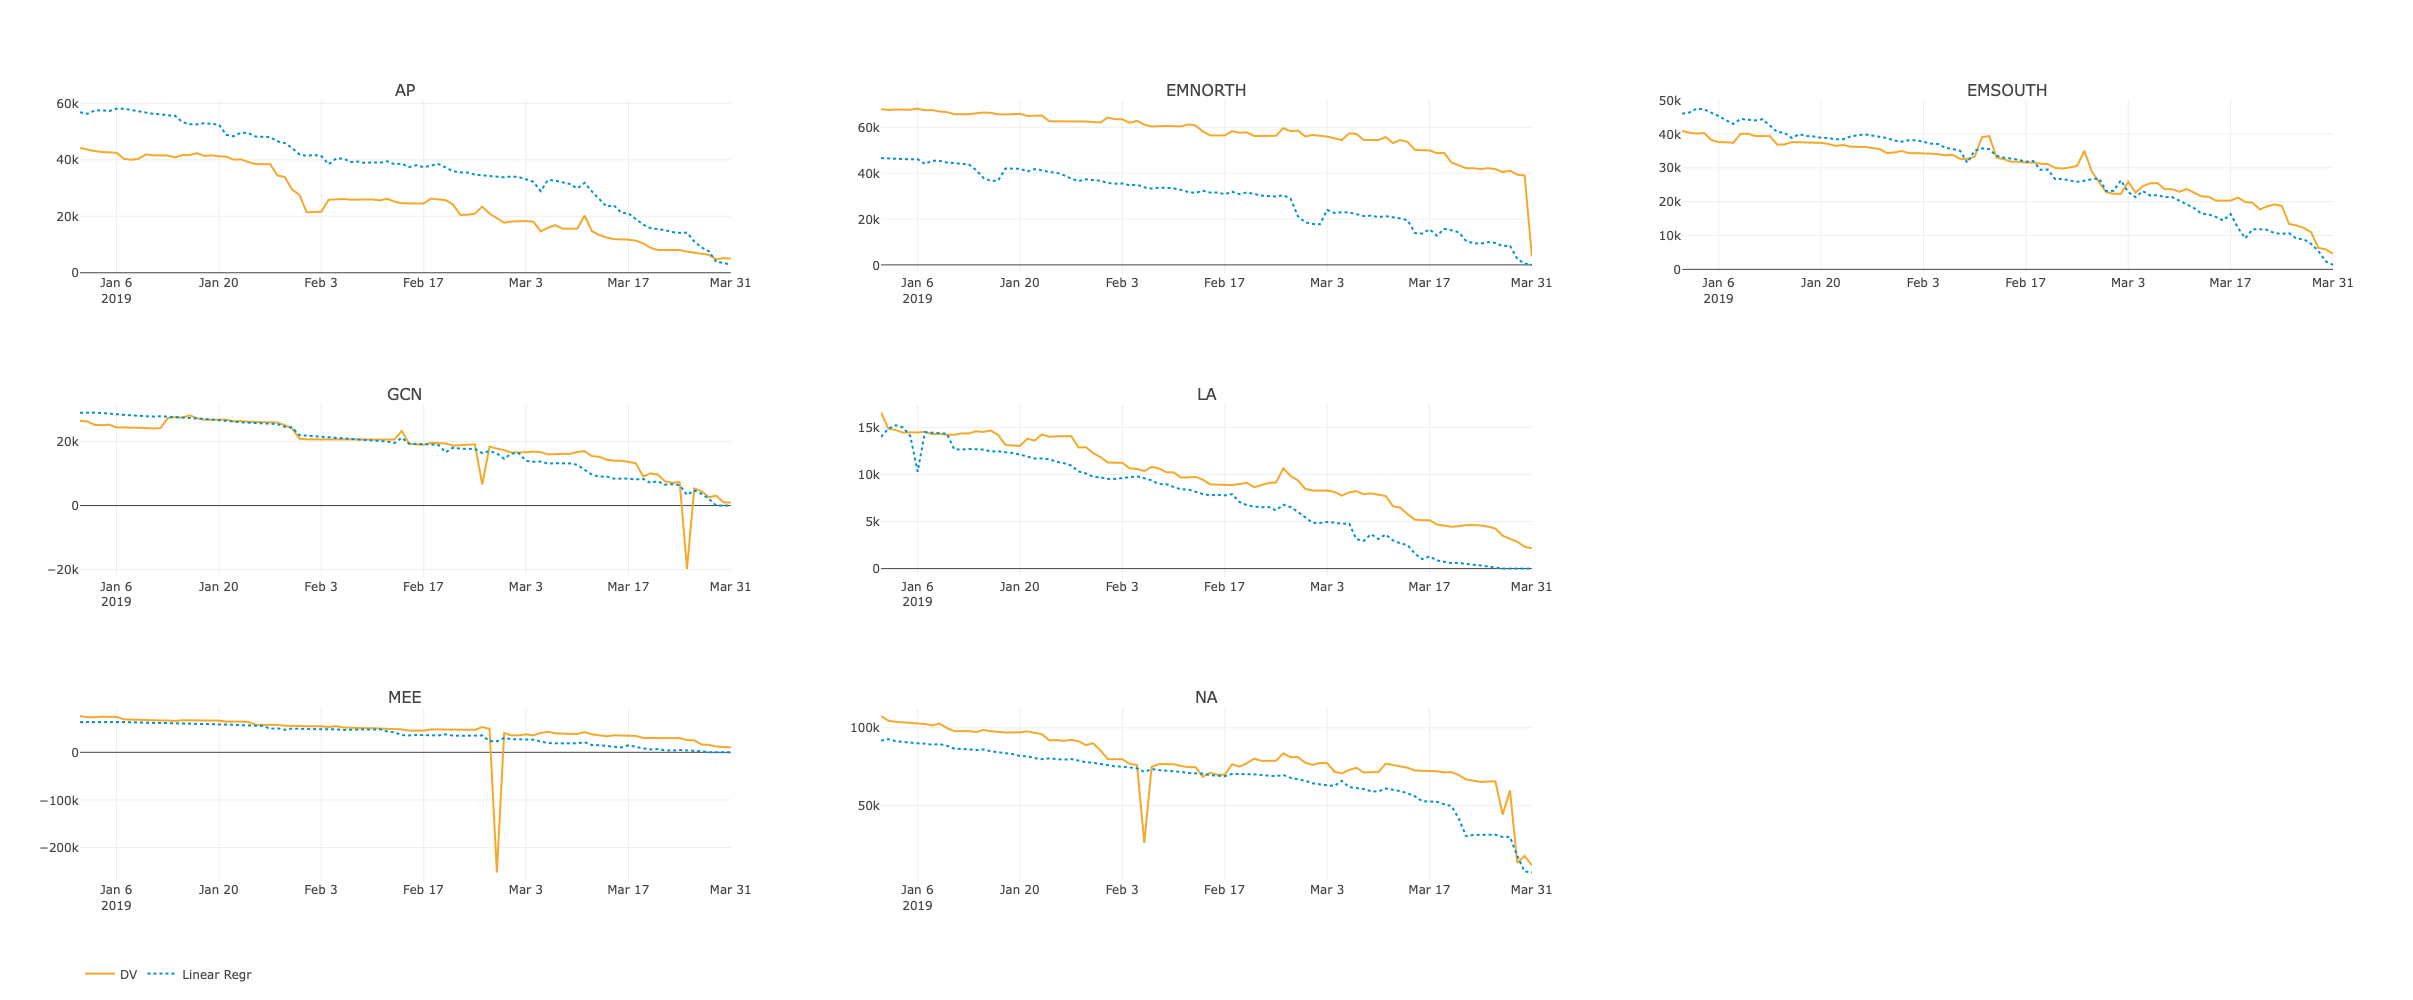

In [2517]:
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go

trace1_AP = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['DV']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV'
)
trace2_AP = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['LinearRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Linear Regr'
)
trace1_EN = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['DV']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_EN = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['LinearRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Linear Regr',
    showlegend=False
)
trace1_ES = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['DV']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_ES = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['LinearRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Linear Regr',
    showlegend=False
)
trace1_GC = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['DV']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_GC = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['LinearRegr']].values.squeeze(),
       line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Linear Regr',
    showlegend=False
)
trace1_LA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['DV']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_LA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['LinearRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Linear Regr',
    showlegend=False
)
trace1_ME = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['DV']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_ME = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['LinearRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Linear Regr',
    showlegend=False
)
trace1_NA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['DV']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_NA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['LinearRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Linear Regr',
    showlegend=False
)

fig = tools.make_subplots(rows=3, cols=3, subplot_titles=('AP', 'EMNORTH', 'EMSOUTH', 
                                                          'GCN', 'LA', '',
                                                         'MEE', 'NA'))
fig.append_trace(trace1_AP, 1, 1)
fig.append_trace(trace2_AP, 1, 1)
fig.append_trace(trace1_EN, 1, 2)
fig.append_trace(trace2_EN, 1, 2)
fig.append_trace(trace1_ES, 1, 3)
fig.append_trace(trace2_ES, 1, 3)
fig.append_trace(trace1_GC, 2, 1)
fig.append_trace(trace2_GC, 2, 1)
fig.append_trace(trace1_LA, 2, 2)
fig.append_trace(trace2_LA, 2, 2)
fig.append_trace(trace1_ME, 3, 1)
fig.append_trace(trace2_ME, 3, 1)
fig.append_trace(trace1_NA, 3, 2)
fig.append_trace(trace2_NA, 3, 2)

fig['layout'].update(height=1000, width=1800, 
                     legend=dict(orientation="h"))

py.iplot(fig, filename='make-subplots-multiple-with-titles')

In [2518]:
#import sys
#!{sys.executable} -m pip install pivottablejs 

from pivottablejs import pivot_ui

pivot_ui(holdout.loc[(holdout.DayInQuarter_asc > 15) & (holdout.DayInQuarter_asc < 75),
                                    ['LinearRegr', 'GLOBAL_01_CODE', 'DayInQuarter_asc', 'MAPE_LR']], 
        vals=['MAPE_LR'],
        aggregatorName='Average',
        rows=['GLOBAL_01_CODE'])

### Lasso regression

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



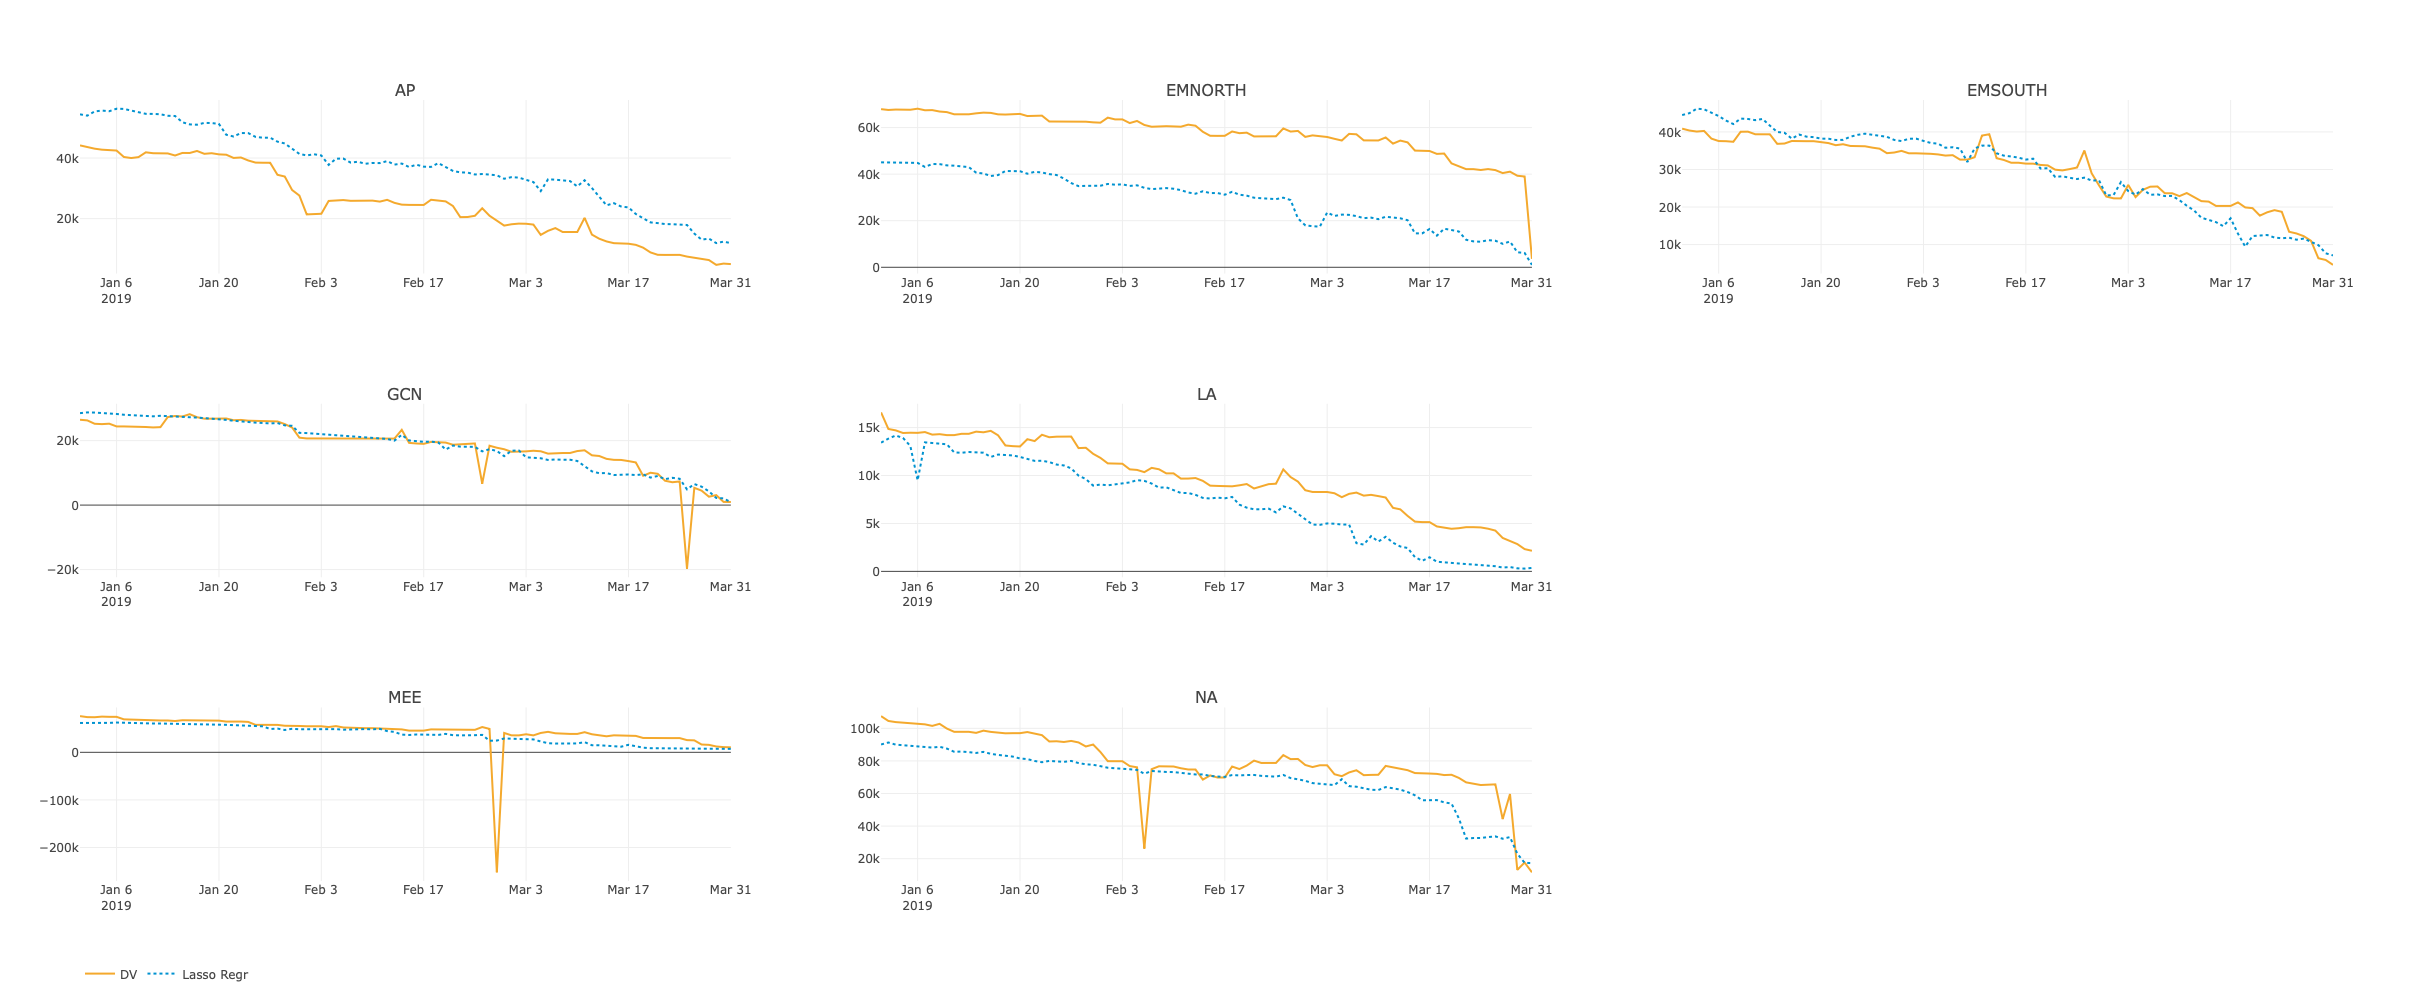

In [2519]:
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go

trace1_AP = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['DV']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV'
)
trace2_AP = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['LassoRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Lasso Regr'
)
trace1_EN = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['DV']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_EN = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['LassoRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Lasso Regr',
    showlegend=False
)
trace1_ES = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['DV']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_ES = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['LassoRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Lasso Regr',
    showlegend=False
)
trace1_GC = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['DV']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_GC = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['LassoRegr']].values.squeeze(),
       line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Lasso Regr',
    showlegend=False
)
trace1_LA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['DV']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_LA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['LassoRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Lasso Regr',
    showlegend=False
)
trace1_ME = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['DV']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_ME = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['LassoRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Lasso Regr',
    showlegend=False
)
trace1_NA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['DV']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_NA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['LassoRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Lasso Regr',
    showlegend=False
)

fig = tools.make_subplots(rows=3, cols=3, subplot_titles=('AP', 'EMNORTH', 'EMSOUTH', 
                                                          'GCN', 'LA', '',
                                                         'MEE', 'NA'))
fig.append_trace(trace1_AP, 1, 1)
fig.append_trace(trace2_AP, 1, 1)
fig.append_trace(trace1_EN, 1, 2)
fig.append_trace(trace2_EN, 1, 2)
fig.append_trace(trace1_ES, 1, 3)
fig.append_trace(trace2_ES, 1, 3)
fig.append_trace(trace1_GC, 2, 1)
fig.append_trace(trace2_GC, 2, 1)
fig.append_trace(trace1_LA, 2, 2)
fig.append_trace(trace2_LA, 2, 2)
fig.append_trace(trace1_ME, 3, 1)
fig.append_trace(trace2_ME, 3, 1)
fig.append_trace(trace1_NA, 3, 2)
fig.append_trace(trace2_NA, 3, 2)

fig['layout'].update(height=1000, width=1800, 
                     legend=dict(orientation="h"))

py.iplot(fig, filename='make-subplots-multiple-with-titles')

In [2520]:
from pivottablejs import pivot_ui

pivot_ui(holdout.loc[(holdout.DayInQuarter_asc > 15) & (holdout.DayInQuarter_asc < 75),
                                    ['LinearRegr', 'GLOBAL_01_CODE', 'DayInQuarter_asc', 'MAPE_Lasso']], 
        vals=['MAPE_Lasso'],
        aggregatorName='Average',
        rows=['GLOBAL_01_CODE'])

# structure Holdout sampe

In [2521]:
holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['DV', 'LinearRegr',  'BUDGET', 'DayInQuarter_asc']].head(0)

,DV,LinearRegr,BUDGET,DayInQuarter_asc


In [2522]:
holdout.head(2)

,level_0,index,SnapDate,DayInQuarter,DayInQuarter_asc,GLOBAL_01_CODE,CLOSING_QUARTER_ACTUAL,QuarterIndex,ACTUAL,BUDGET,...,LinearityBudget_rolling,Delta_EstIn,Delta_OpenPipe,Ratio_DVBud,UpperBoundary,LowerBoundary,LinearRegr,MAPE_LR,LassoRegr,MAPE_Lasso
0,0,2555,2019-01-01,90,1,AP,2019-Q1,5,97929.92153,104904.04286,...,50890.227694,33.591131,-12207.70556,0.42110,62942.425716,31471.212858,56824.554112,0.286349,54417.689934,0.231865
1,7,2562,2019-01-02,89,2,AP,2019-Q1,5,97929.92153,104904.04286,...,50579.126715,33.591131,-12207.70556,0.41523,62592.745573,31121.532715,56279.345305,0.292018,53981.233112,0.239260


## Stepwise linear regression

In [2523]:
import statsmodels.api as sm

def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = backward_regression(train.loc[: , 'ESTIMATED_IN' : 'Delta_OpenPipe'], train['DV'], 0.1)

print('resulting features:')
result

resulting features:


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



['ESTIMATED_IN',
 'Linearity_EstIn_1Q',
 'Linearity_Budget_1Q',
 'LinearityEstIn_rolling',
 'LinearityBudget_rolling',
 'Delta_EstIn',
 'Delta_OpenPipe']

In [2524]:
def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

result = forward_regression(train.loc[: , 'ESTIMATED_IN' : 'Delta_OpenPipe'], train['DV'], 0.1)

print('resulting features:')
result

resulting features:


['LinearityBudget_rolling',
 'Linearity_Budget_1Q',
 'ESTIMATED_IN',
 'LinearityEstIn_rolling',
 'Delta_OpenPipe',
 'Linearity_EstIn_1Q',
 'Delta_EstIn']

# csv export

In [94]:
#holdout.to_csv("~/OneDrive - SAP SE/1 Projects/160629_PipelineForecasting/GIT/Licenses/Rebuild1811/model2.csv")

#holdout.to_csv("/Users/i513088/Desktop/Final-model/model2_count.csv")

In [ ]:
holdout.to_csv("/Users/i513088/Desktop/Final-model/model2_bootstrap/model2_MLP/model2_count_MLP_Q1.csv")